In [1]:
import numpy as np
import torch
from problems import *
from matplotlib import pyplot as plt
from IPython.display import clear_output
from copy import deepcopy
import pandas as pd

# Calculus of variations with NN (pytorch)

## 1. Problem statement

Пусть стоит задача
$$\begin{cases}
\displaystyle \int\limits_{t_0}^{t_f} f\big(t, x(t), \dot{x}(t)\big) dt \longrightarrow \min_{x(t)} \\
\displaystyle x(t_0) = x_0, \ \ \ x(t_f) = x_f
\end{cases}$$

Пусть для примера
$$f(t,x,\dot{x}) = x^2 + t\dot{x} + \dot{x}^2, \ \ \ \ x(0) = 0, \ \ x(1) = 0.25$$

## 2. Building the loss function

### 2.1 Main functional loss

$$\widehat{J}_0(x) = \sum_{k=0}^{N-1} f \big(t_k, x_k, \dot{x}_k(x)\big) \cdot h \longrightarrow \min_{x_1, \ldots, x_{N-1}}$$

Если точки $x_i$ вычисляются косвенно, то есть $x = x(\theta),$ где $\theta$ - еще какие-то параметры, то $\widehat{J}_0 = \widehat{J}_0(\theta)$.

In [13]:
def rectangle_left_rule(t, x, xp, f):
    # t = (t_0, ..., t_N) - torch.tensor,
    # x = (x_0,..., x_N) - torch.tensor
    # xp = (xp_0, ..., xp_N) - torch.tensor
    # f - given function
    
    h = t[1] - t[0] # time step    
    return torch.sum(f(t[:-1], x[:-1], xp[:-1])) * h

def trapezoidal_rule(t, x, xp, f):
    h = t[1] - t[0] # time step
    return torch.sum(f(t[:-1], x[:-1], xp[:-1]) + f(t[1:], x[1:], xp[1:])) * h / 2

def simpsons_rule(t, x, xp, f):
    h = t[1] - t[0] # time step
    return (2*torch.sum(f(t[::2], x[::2], xp[::2])) + 4*torch.sum(f(t[1::2], x[1::2], xp[1::2])) - f(t[0], x[0], xp[0]) - f(t[-1], x[-1], xp[-1]))


### 2.2 Known points loss

Если мы знаем, через какие точки $(t_j^\ast, x_j^\ast)$ должно проходить решение, то можно сделать добавку

$$\widehat{J}_{\text{points}}(\theta) = \sum_{j=1}^m \big\lvert \ x(t_j^\ast, \theta) - x_j^\ast \big\rvert^2$$

In [5]:
def J_points(x, x_star):
    # x_star = (x*_1, ..., x*_m) - known values at points t*_1, ..., t*_m - torch.tensor
    # x = (x_1, ..., x_m) - predictions at points t*_1, ..., t*_m - torch.tensor
    
    return torch.sum((x - x_star) * (x - x_star))

### 2.3 Total loss

$$\widehat{J}(\theta) = \widehat{J}_0(x(\theta)) + \lambda_p \widehat{J}_p(\theta) + \lambda_1 \lVert \theta \rVert_1 + \lambda_2 \lVert \theta \rVert^2_2$$

## 3. Model construction

In [6]:
def simple_transform(t, x, t_0, t_f, x_0, x_f):
    # t, x - torch.tensor's
    # t_0, t_f, x_0, x_f - scalars
    return x_0 + (x_f - x_0) / (t_f - t_0) * (t - t_0) + (t - t_0) * (t - t_f) * x

def identity_transform(t, x, t_0, t_f, x_0, x_f):
    return x

In [7]:
class CosineLayer(torch.nn.Module):
    def forward(self, x):
        n_basis = x.size()[1]
        out = tuple(torch.cos(n * x[:,n]).view(-1,1) for n in range(n_basis))
        return torch.cat(out, dim=1)
    
class PowerLayer(torch.nn.Module):
    def forward(self, x):
        n_basis = x.size()[1]
        out = tuple(torch.pow(x[:,n], n).view(-1,1) for n in range(n_basis))
        return torch.cat(out, dim=1)

In [8]:
class CVmodel(torch.nn.Module):
    def __init__(self, problem, sizes, activations=None, transform_func=simple_transform, 
                 biases=None, fix_first_ones=False):
        # sizes - list of sizes of hidden layers, input and outplut layers always have size 1
            # (Ex: sizes = [4, 5] will create a 1-4-5-1 network)
        # activations - list of length len(sizes)+1, contains activation functions of each layer
        # transform_func - transformation of final output to fit for boundary conditions
        # biases - list of length len(sizes)+1, contains True/False values for each layer
        # fix_first_ones - True/False
    
        super(CVmodel, self).__init__()
        
        self.problem = problem
        self.sizes = [1] + sizes + [1]
        n_layers = len(sizes)+1
        
        biases_ = biases
        if biases_ is None:
            biases_ = [True] * n_layers
        if len(biases_) != n_layers:
            print("Error: length of biases list is not equal to the number of layers")
            biases_ = [True] * n_layers
        if fix_first_ones:
            biases_[0] = False
            
        self.layers = torch.nn.ModuleList()
        for i in range(n_layers):
            layer = torch.nn.Linear(self.sizes[i], self.sizes[i+1], bias=biases_[i])
            if i == 0 and fix_first_ones:
                layer.weight.data = torch.ones_like(layer.weight.data)
                layer.weight.requires_grad = False
            self.layers.append(layer)
        
        if activations is None:
            self.activations = [torch.nn.Sigmoid()] * n_layers
        elif len(activations) != n_layers:
            print("Error: length of activations list is not equal to the number of layers")
            self.activations = [torch.nn.Sigmoid()] * n_layers
        else:
            self.activations = activations
            
        self.transform_func = transform_func
            
    def transform(self, t, x):
        return self.transform_func(t, x, self.problem.t_0, self.problem.t_f, self.problem.x_0, self.problem.x_f)

    def forward(self, x):
        y = x
        for lay, act in zip(self.layers, self.activations):
            y = act(lay(y))
        # applying a transformation to fit boundary conditions
        y = self.transform(x,y)
        return y
    
    def forward_prime(self, x, h=0.0001):
        # implements forward finite difference method for first derivative       
        return (self.forward(x+h) - self.forward(x-h)) / h / 2
    
    def optimize_SGD(self, N, n_epochs, functional_loss=rectangle_left_method, lr=0.1, lr_scheduler=(2000,0.3),
                     momentum=0.0, lambda_points=0.0, lambda_1=0.0, lambda_2=0.0,
                     verbose=True):
        # N - number of subsegments to divide the segment in
        # n_epochs - number of SGD cycles
        # functional_loss - main integral functional loss - function of (t, x, xp, f)
        # lr - learning rate
        # lr_scheduler - tuple(step, gamma) - for torch.optim.lr_scheduler.StepLR
        # momentum - momentum coefficient
        # lambda_points - coefficient in front of known points loss function
        # lambda_smooth - coefficient in front of smoothness loss function
        # lambda_1 - L1-regularizer
        # lambda_2 - L2-regularizer
        # verbose - whether to print out the progress
        
        errors_abs = []
        errors_rel = []
        best_err_iter = None
        best_err_err = None
        best_err_xs = None
        best_loss_iter = None
        best_loss_err = None
        best_loss_xs = None
        
        optimizer = torch.optim.SGD(self.parameters(), lr=lr, momentum=momentum)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_scheduler[0], lr_scheduler[1])
        
        x_0 = self.problem.x_0
        x_f = self.problem.x_f
        t_0 = self.problem.t_0
        t_f = self.problem.t_f
        x_exact = self.problem.x_exact
        f = self.problem.f
        ts = torch.linspace(t_0,t_f,N+1)
        x_exact_norm = np.mean(np.abs(x_exact(np.linspace(t_0,t_f,N+1)[:-1])))
        
        if verbose:
            print('Optimal:', functional_loss(ts, x_exact(ts), (x_exact(ts+0.0005) - x_exact(ts)) / 0.0005, f).item())
        
        for i in range(n_epochs):
            
            # compute loss
            xs = self.forward(ts[1:-1].view(-1,1))
            xs_full = torch.cat((torch.tensor([x_0]).float(), xs.flatten(), torch.tensor([x_f]).float()))
            xps = self.forward_prime(ts.view(-1,1))
            #print(xs_full)
            #print(xps.flatten())
            loss = functional_loss(ts, xs_full, xps.flatten(), f)
            for param in self.parameters():
                loss = loss + lambda_1 * torch.sum(torch.abs(param)) + lambda_2 * torch.sum(param * param)
            if self.problem.t_known is not None:
                x_hat = self.forward(self.problem.t_known)
                loss = loss + lambda_points * J_points(x_hat, self.problem.x_known)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            scheduler.step()

            err = self.problem.compute_error(xs.flatten().data.numpy())
            errors_abs.append(err)
            errors_rel.append(err / x_exact_norm)

            if best_err_err is not None:
                if err < best_err_err:
                    best_err_iter = i
                    best_err_err = err
                    best_err_xs = xs.flatten().data.numpy()
            else:
                best_err_iter = i
                best_err_err = err
                best_err_xs = xs.flatten().data.numpy()

            if best_loss_err is not None:
                if loss.item() < best_loss_err:
                    best_loss_iter = i
                    best_loss_err = loss.item()
                    best_loss_xs = xs.flatten().data.numpy()
            else:
                best_loss_iter = i
                best_loss_err = loss.item()
                best_loss_xs = xs.flatten().data.numpy()


            if (verbose is True) and ((i+1) % (n_epochs // 10) == 0):
                print("Epoch  {0}: loss = {1}".format(i+1, loss.item()))


        best_err_xs = np.concatenate(([x_0], best_err_xs, [x_f])) 
        best_loss_xs = np.concatenate(([x_0], best_loss_xs, [x_f]))

        if verbose:
            print("Best loss achieved at iteration {0}: {1}".format(best_loss_iter+1, best_loss_err))
            print("Best L1 error achieved at iteration {0}: {1}, {2}".format(best_err_iter+1, best_err_err, best_err_err/x_exact_norm))
            
        return errors_abs, errors_rel, best_err_err, best_err_xs, best_loss_err, best_loss_xs            

### 3.1 Basic test model

In [18]:
nn1 = CVmodel(constrained_problems[0], [3], activations=(torch.nn.Tanh(), torch.nn.Identity()))
nn1b = CVmodel(constrained_problems[0], [3], activations=(torch.nn.Tanh(), torch.nn.Identity()))

In [19]:
nn1_errors_abs, nn1_errors_rel, nn1_best_err, x_nn1_best_err, nn1_best_loss, x_nn1_best_loss = nn1.optimize_SGD(
    500, 5000, functional_loss=trapezoidal_method, lr=0.005, lr_scheduler=(3000,0.5), momentum=0.1)

nn1b_errors_abs, nn1b_errors_rel, nn1b_best_err, x_nn1b_best_err, nn1b_best_loss, x_nn1b_best_loss = nn1b.optimize_SGD(
    500, 5000, functional_loss=trapezoidal_method, lr=0.005, lr_scheduler=(3000,0.5), momentum=0.1)

Optimal: 0.19750896096229553
Epoch  500: loss = 0.1993279904127121
Epoch  1000: loss = 0.19879832863807678
Epoch  1500: loss = 0.1984601467847824
Epoch  2000: loss = 0.198236346244812
Epoch  2500: loss = 0.1980804204940796
Epoch  3000: loss = 0.19796738028526306
Epoch  3500: loss = 0.19792884588241577
Epoch  4000: loss = 0.19789282977581024
Epoch  4500: loss = 0.1978570967912674
Epoch  5000: loss = 0.19783258438110352
Best loss achieved at iteration 4988: 0.19783082604408264
Best L1 error achieved at iteration 5000: 0.0019273025038383728, 0.012583423407165964
Optimal: 0.19750896096229553
Epoch  500: loss = 0.1994064897298813
Epoch  1000: loss = 0.19870229065418243
Epoch  1500: loss = 0.19828037917613983
Epoch  2000: loss = 0.19802571833133698
Epoch  2500: loss = 0.19786924123764038
Epoch  3000: loss = 0.19777549803256989
Epoch  3500: loss = 0.1977444887161255
Epoch  4000: loss = 0.19771763682365417
Epoch  4500: loss = 0.19770130515098572
Epoch  5000: loss = 0.19768425822257996
Best los

### 3.2 Cosine series

In [ ]:
nn2 = CVmodel(test_problem, [20], activations=[CosineLayer(), torch.nn.Identity()], fix_first_ones=True)

In [ ]:
nn2_errors_abs, nn2_errors_rel, nn2_best_err, x_nn2_best_err, nn2_best_loss, x_nn2_best_loss = nn2.optimize_SGD(
    5000, 5000, lr=0.001, lr_scheduler=(2500,0.2), momentum=0.1, lambda_1=0.001)

In [ ]:
[p for p in nn2.parameters()]

### 3.3 Power series

In [ ]:
nn3 = CVmodel(test_problem, [5], activations=[PowerLayer(), torch.nn.Identity()], fix_first_ones=True)

In [ ]:
nn3_errors_abs, nn3_errors_rel, nn3_best_err, x_nn3_best_err, nn3_best_loss, x_nn3_best_loss = nn3.optimize_SGD(
    5000, 5000, lr=0.005, lr_scheduler=(2500,0.2), momentum=0.2, lambda_1=0.001)

In [ ]:
[p for p in nn3.parameters()]

### 3.4 Cosine + power series

In [ ]:
nn4 = CVmodel(test_problem, [5,15],
              activations=[PowerLayer(), CosineLayer(), torch.nn.Identity()],
              fix_first_ones=True)

In [ ]:
nn4_errors_abs, nn4_errors_rel, nn4_best_err, x_nn4_best_err, nn4_best_loss, x_nn4_best_loss = nn4.optimize_SGD(
    500, 5000, lr=0.001, lr_scheduler=(2500,0.2), momentum=0.2, lambda_1=0.001)

## 4. Сравнение решений

### 4.1 Сравнение численного и точного решений

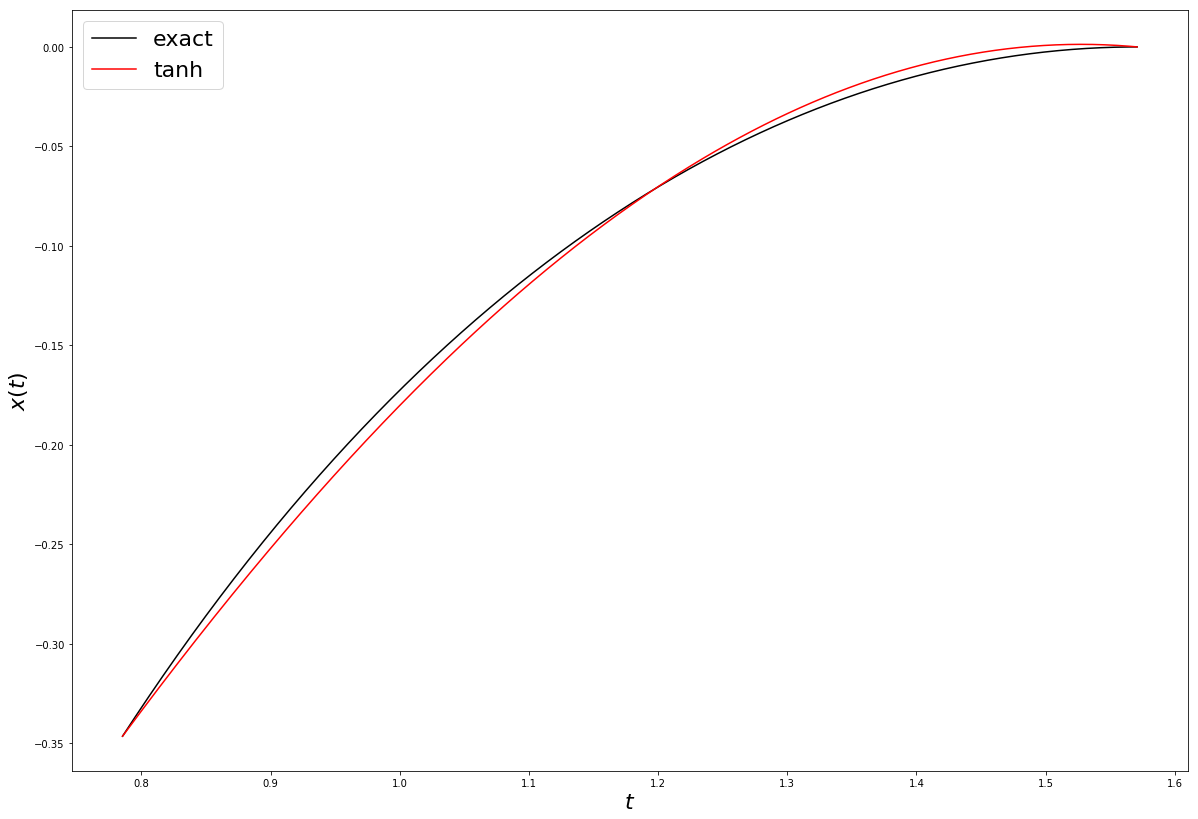

In [9]:
i = 20

ts = np.linspace(constrained_problems[i].t_0, constrained_problems[i].t_f, 501)

plt.figure(figsize=(20,14))
plt.plot(ts, constrained_problems[i].x_exact(ts), color='black', label='exact')
plt.plot(ts, x_nn1_best_err, color='red', label='tanh')
#plt.plot(ts, x_nn2_best_err, color='green', label='cosine')
#plt.plot(ts, x_nn3_best_err, color='blue', label='power')
#plt.plot(ts, x_nn4_best_err, color='orange', label='power + cosine')
plt.xlabel('$t$', fontsize=22)
plt.ylabel('$x(t)$', fontsize=22)
plt.legend(fontsize='22')
plt.show()

### 4.2 Сравнение сходимостей

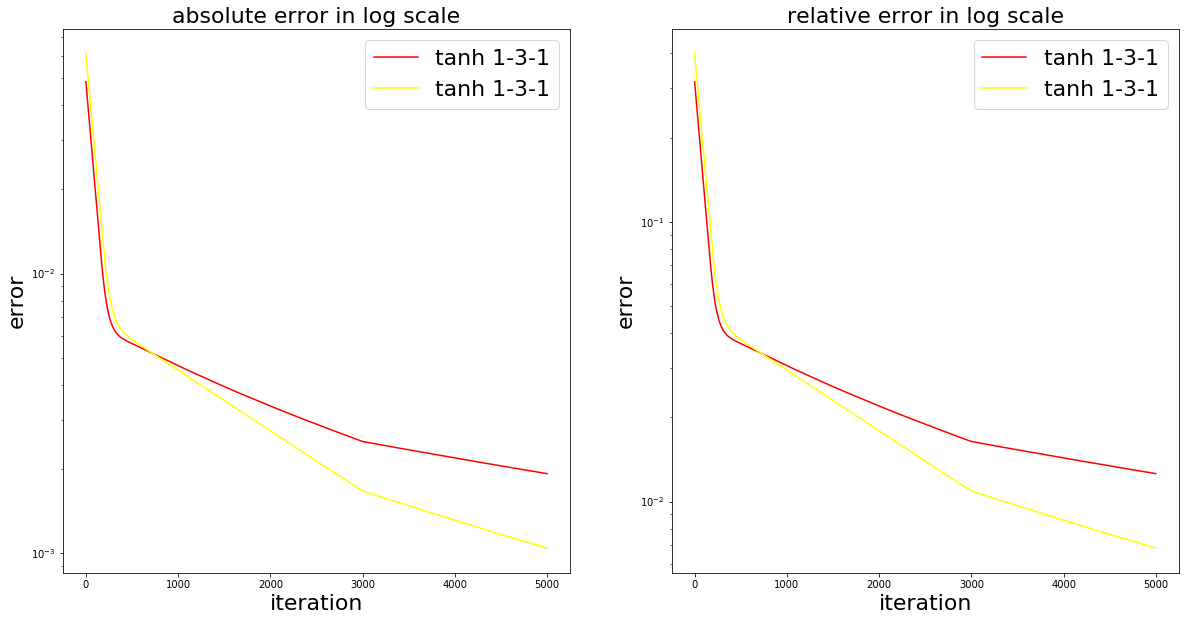

In [20]:
clear_output()

n_skip = 0

fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].plot(range(len(nn1_errors_abs))[n_skip:], nn1_errors_abs[n_skip:], color='red', label='tanh 1-3-1')
ax[0].plot(range(len(nn1b_errors_abs))[n_skip:], nn1b_errors_abs[n_skip:], color='yellow', label='tanh 1-3-1')
#ax[0].plot(range(len(nn2_errors_abs))[n_skip:], nn2_errors_abs[n_skip:], color='green', label='cosine')
#ax[0].plot(range(len(nn3_errors_abs))[n_skip:], nn3_errors_abs[n_skip:], color='blue', label='power')
#ax[0].plot(range(len(nn3_errors_abs))[n_skip:], nn4_errors_abs[n_skip:], color='orange', label='power+cosine')

ax[0].set_xlabel('iteration', fontsize=22)
ax[0].set_ylabel('error', fontsize=22)
ax[0].set_yscale('log')
ax[0].set_title('absolute error in log scale', fontsize=22)
ax[0].legend(fontsize=22)

ax[1].plot(range(len(nn1_errors_rel))[n_skip:], nn1_errors_rel[n_skip:], color='red', label='tanh 1-3-1')
ax[1].plot(range(len(nn1b_errors_rel))[n_skip:], nn1b_errors_rel[n_skip:], color='yellow', label='tanh 1-3-1')
#ax[1].plot(range(len(nn2_errors_rel))[n_skip:], nn2_errors_rel[n_skip:], color='green', label='cosine')
#ax[1].plot(range(len(nn3_errors_rel))[n_skip:], nn3_errors_rel[n_skip:], color='blue', label='power')
#ax[1].plot(range(len(nn4_errors_rel))[n_skip:], nn4_errors_rel[n_skip:], color='orange', label='power+cosine')

ax[1].set_xlabel('iteration', fontsize=22)
ax[1].set_ylabel('error', fontsize=22)
ax[1].set_yscale('log')
ax[1].set_title('relative error in log scale', fontsize=22)
ax[1].legend(fontsize=22)

## 5. Поиск оптимальной модели

In [ ]:
sizes_list = [[4], [10,5], [6,10,6], [10,25,10], [6,6,6,6], [5,7,10,7,5]]
lr_list = list(np.logspace(-5, -1, 7))
l2_list = list(np.logspace(-4, -1, 4))
mom_list = list(np.logspace(-2, -0.5, 5))

n_tests = 3

In [ ]:
results = []
K = 0
for sizes in sizes_list:
    for lr in lr_list:
        for l2 in l2_list:
            for mom in mom_list:
                K += 1
                
                loss_min = []
                err_min = []
                
                for i in range(n_tests):
                    nn = CVmodel(test_problem, sizes)
                    print("Iteration number ", K, "-", i)
                    errors_abs, errors_rel, best_err_err, best_err_xs, best_loss_err, best_loss_xs = nn.optimize_SGD(50,1000,rectangle_left_method, first_order_forward_h,lr=lr,lambda_2=l2,momentum=mom,verbose=False)
                    loss_min.append(best_loss_err)
                    err_min.append(best_err_err)
                
                loss_min = np.array(loss_min)
                err_min = np.array(err_min)
                results.append([sizes, lr, l2, mom, np.mean(loss_min), np.std(loss_min), np.mean(err_min), np.std(err_min)])
                

In [ ]:
results_ = deepcopy(results)

In [ ]:
print(lr_list, l2_list, mom_list)

res_frame = pd.DataFrame(results_)
res_frame.columns = ['sizes', 'learning_rate', 'lambda_2', 'momentum',
                 'loss_mean', 'loss_std', 'error_mean', 'error_std']

In [ ]:
res_frame[res_frame.learning_rate==0.1][res_frame.lambda_2==0.0001].sort_values('error_mean')[:10]